# ADN_T014. Generate molecules with AE from SELFIES using RNN

Authors:
* Adnane Aouidate, (2019-2020), Computer Aided Drug Discovery Center, Shenzhen Institute of Advanced Technology(SIAT), Shenzhen, China.
* Adnane Aouidate, (2021-2022), Structural Bioinformatics and Chemoinformatics, Institute of Organic and Analytical Chemistry (ICOA), Orléans, France.
* Update , 2023, Ait Melloul Faculty of Applied Sciences, Ibn Zohr University, Agadir, Morocco,

## Aim of this talktorial

In the current tutorial I am going to teach you how to get create a generative moelcules with keras using LSTM (Long Short Term Memory) models. Generative models are very usufel and well known, they are also useful for drug discovery research and are frequently utilized by academic and industrial researchers.

Let's get statrted 



In [64]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import selfies as sf
from IPython.display import display

from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, PandasTools
from rdkit.Chem.Draw import IPythonConsole

from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA   
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Concatenate
from keras import regularizers
from keras.callbacks import History, ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam

# Read a dataset of smiles and convert them to mol using rdkit and pandas

In [84]:
#@ GETTING THE DATA:
PATH = "./databases/TasteDB.smi"                           # Path to the Data. 
data = pd.read_csv(PATH, delimiter="\t", names=["smiles"])         # Reading the Data. 
display(data.head())                                                            # Inspecting the Data

,smiles
0,C1=CC=C2N=CN=CC2=C1
1,C1=CC(=CC=N1)C1=CC=NC=C1
2,C1CCN2N=NN=C2CC1
3,C1CC[NH2+]CC1
4,C1CC[NH+]2C[C@H]3C[C@H](C[NH+]4CCCC[C@H]34)[C@...


In [85]:
PandasTools.AddMoleculeColumnToFrame(data, smilesCol="smiles")

[21:15:33] Explicit valence for atom # 11 N, 4, is greater than permitted
[21:15:33] Explicit valence for atom # 1 N, 4, is greater than permitted


,smiles,ROMol
0,C1=CC=C2N=CN=CC2=C1,

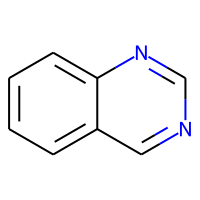

In [86]:
data.head(1)

In [87]:
data.ROMol.isna().sum()

2

In [88]:
data.dropna(how='any', inplace=True)

In [89]:
data["canonical_smiles"] = data["ROMol"].apply(lambda mol : Chem.MolToSmiles(mol))

,smiles,ROMol,canonical_smiles
0,C1=CC=C2N=CN=CC2=C1,,c1ccc2ncncc2c1

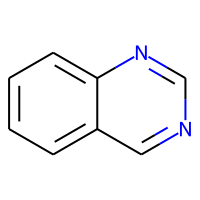

In [91]:
data.head(1)

In [93]:
data.drop(columns=['smiles'], inplace=True)

In [97]:
sf.set_semantic_constraints()  # reset constraints
constraints = sf.get_semantic_constraints()
constraints['?'] = 4

sf.set_semantic_constraints(constraints)
constraints

{'H': 1,
 'F': 1,
 'Cl': 1,
 'Br': 1,
 'I': 1,
 'B': 3,
 'B+1': 2,
 'B-1': 4,
 'O': 2,
 'O+1': 3,
 'O-1': 1,
 'N': 3,
 'N+1': 4,
 'N-1': 2,
 'C': 4,
 'C+1': 5,
 'C-1': 3,
 'P': 5,
 'P+1': 6,
 'P-1': 4,
 'S': 6,
 'S+1': 7,
 'S-1': 5,
 '?': 4}

In [98]:
def preprocess_smiles(canonical_smiles):
    return sf.encoder(canonical_smiles)  

data['selfies'] = data['canonical_smiles'].apply(preprocess_smiles)

,ROMol,canonical_smiles,selfies
0,,c1ccc2ncncc2c1,[C][=C][C][=C][N][=C][N][=C][C][Ring1][=Branch...
1,,c1cc(-c2ccncc2)ccn1,[C][=C][C][Branch1][=Branch2][C][=C][C][=N][C]...
2,,C1CCc2nnnn2CC1,[C][C][C][C][=N][N][=N][N][Ring1][Branch1][C][...
3,,C1CC[NH2+]CC1,[C][C][C][NH2+1][C][C][Ring1][=Branch1]
4,,C1CC[NH+]2C[C@H]3C[C@H](C[NH+]4CCCC[C@H]34)[C@...,[C][C][C][NH1+1][C][C@H1][C][C@H1][Branch1][N]...

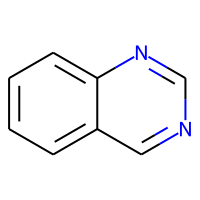
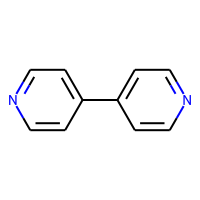
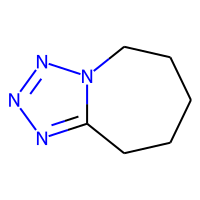
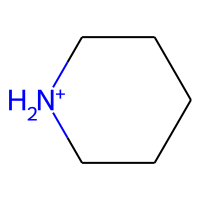
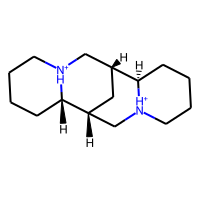

In [100]:
data.head()

In [101]:
selfies_train, selfies_test = train_test_split(data["selfies"], random_state=42)   # Splitting the Data. 
display(selfies_train.shape, selfies_test.shape)                                  # Inspecting the shape of Train and Test Data. 

(603,)

(201,)

In [107]:
#@ PREPARING THE DATA:
charset = set("".join(list(data.selfies)) + "!E")
char_to_int = dict((c, i) for i, c in enumerate(charset))            # Converting the Characters to Index. 
int_to_char = dict((i, c) for i, c in enumerate(charset))            # Converting the Index to Characters. 
emmbed = max([len(selfie) for selfie in data.selfies]) + 3              # Maximum length of the SMILES strings. 
print(str(charset))                                                  # Inspecting the Characterset. 
print(len(charset), emmbed)    

{'-', 'E', '=', 'S', '!', 'P', 'N', ']', 'l', 'h', '#', '/', 'c', '[', 'R', 'a', '2', 'H', '+', 'O', 'g', 'i', '\\', 'I', 'F', 'B', '1', 'C', 'r', 'n', '@', '3'}
32 807


[C][=C][C][Branch1][C][C][Branch1][=Branch2][C][C][C][=C][Branch1][C][C][C][O][C][=O]


(603, 806, 32)

(603, 806, 32)

(201, 806, 32)

![C][=C][C][Branch1][C][C][Branch1][=Branch2][C][C][C][=C][Branch1][C][C][C][O][C][=O]EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE


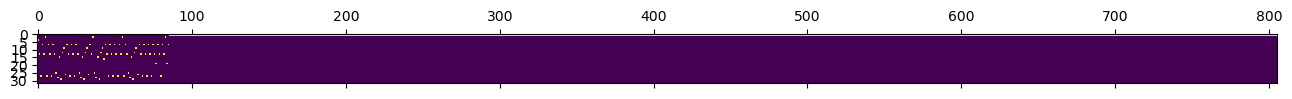

In [108]:
#@ PREPARING THE DATA:
def vectorize(selfies):                                                          # Vectorization.
    one_hot = np.zeros((selfies.shape[0], emmbed, len(charset)), dtype=np.int8)    # Initialization of an empty numpy array.
    for i, selfie in enumerate(selfies):
        one_hot[i, 0, char_to_int["!"]] = 1                                         # Encoding the starting character. 
        for j, c in enumerate(selfie):
            one_hot[i, j+1, char_to_int[c]] = 1                                       # Encoding the rest of the characters. 
            one_hot[i, len(selfie)+1:, char_to_int["E"]] = 1                             # Encoding the ending character. 
    return one_hot[:, 0:-1, :], one_hot[:, 1:, :]
X_train, y_train = vectorize(selfies_train.values)                               # Encoding the Training set. 
X_test, y_test = vectorize(selfies_test.values)                                  # Encoding the Test set. 
print(selfies_train.iloc[0])                                                     # Inspecting the Data.
plt.matshow(X_train[0].T)                                                       # Data Visualization of the arrays. 
display(X_train.shape, y_train.shape, X_test.shape)                             # Inspecting the shape of Data. 
print("".join([int_to_char[idx] for idx in np.argmax(X_train[0,:,:], axis=1)])) # Converting the Index into Characters. 

In [110]:
#@ LONG SHORT TERM MEMORY:
input_shape = X_train.shape[1:]                                           # Shape of input.
output_dim = y_train.shape[-1]                                            # Shape of output. 
latent_dim = 64
lstm_dim = 64
#@ ENCODER:
unroll = False
encoder_inputs = Input(shape=input_shape)                                 # Inputs of the Encoder. 
encoder = LSTM(lstm_dim, return_state=True, unroll=unroll)                # Encoder using LSTM. 
encoder_outputs, state_h, state_c = encoder(encoder_inputs)               
states = Concatenate(axis=-1)([state_h, state_c])                         # Concatenation of two states. 
neck = Dense(latent_dim, activation="relu")                               # Implementation of RELU.
neck_outputs = neck(states)
#@ DECODER:
decode_h = Dense(lstm_dim, activation="relu")                             # Implementation of Decoder. 
decode_c = Dense(lstm_dim, activation="relu")                             # Implementation of Decoder. 
state_h_decoded = decode_h(neck_outputs)                                  # Decoder.
state_c_decoded = decode_c(neck_outputs)                                  # Decoder.
encoder_states = [state_h_decoded, state_c_decoded]
decoder_inputs =  Input(shape=input_shape)
decoder_lstm = LSTM(lstm_dim, return_sequences=True, unroll=unroll)          # Implementation of LSTM.
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(output_dim, activation="softmax")                      # Output Layer.
decoder_outputs = decoder_dense(decoder_outputs)                             # Implemenatation of Decoders. 
#@ DEFINING THE MODEL:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)             # Instantiating the Model. 
display(model.summary())  

2023-03-20 21:29:04.835130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 806, 32)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 64),         24832       ['input_1[0][0]']                
                                 (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                                  
 concatenate (Concatenate)      (None, 128)          0           ['lstm[0][1]',                   
                                                                  'lstm[0][2]']               

None

In [111]:
history = History()                                                    # Instantiating the History Module. 
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10,
                        min_lr=0.000001, verbose=1, min_delta=1e-5)    # Instantiating the Module for Learning Rate. 
optimizer = Adam(learning_rate=0.005)                                             # Initializing the Adam Optimizer. 
model.compile(optimizer=optimizer, loss="categorical_crossentropy")    # Compiling the Model.
model.fit([X_train, X_train], y_train, epochs=200,                     # Using the Training Data. 
          batch_size=256, shuffle=True, callbacks=[history, rlr],      # Implementation of Callbacks. 
          validation_data=([X_test, X_test], y_test))                  # Training the Model.        

Epoch 1/200


/Users/adnane/opt/anaconda3/envs/ADN/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


3/3 [==============================] - 6s 2s/step - loss: 3.2524 - val_loss: 2.2030 - lr: 0.0050
Epoch 2/200
3/3 [==============================] - 4s 1s/step - loss: 1.7723 - val_loss: 1.1332 - lr: 0.0050
Epoch 3/200
3/3 [==============================] - 4s 1s/step - loss: 1.1424 - val_loss: 0.8208 - lr: 0.0050
Epoch 4/200
3/3 [==============================] - 4s 1s/step - loss: 0.8614 - val_loss: 0.8546 - lr: 0.0050
Epoch 5/200
3/3 [==============================] - 4s 1s/step - loss: 0.8817 - val_loss: 0.8193 - lr: 0.0050
Epoch 6/200
3/3 [==============================] - 4s 1s/step - loss: 0.8358 - val_loss: 0.7654 - lr: 0.0050
Epoch 7/200
3/3 [==============================] - 4s 1s/step - loss: 0.7850 - val_loss: 0.7270 - lr: 0.0050
Epoch 8/200
3/3 [==============================] - 4s 1s/step - loss: 0.7487 - val_loss: 0.6977 - lr: 0.0050
Epoch 9/200
3/3 [==============================] - 4s 1s/step - loss: 0.7198 - val_loss: 0.6722 - lr: 0.0050
Epoch 10/200
3/3 [=============

In [112]:
#@ SAVING THE MODEL:
import pickle
filename = "FirstSelfiesmodel.pickle"                        # Name of the file. 
pickle.dump(history.history, open(filename, "wb"))    # Saving the Model. 

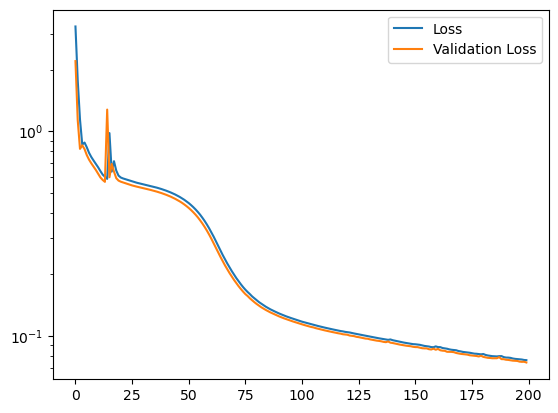

In [113]:
#@ PLOTTING THE TRAINING PROCESS:
plt.plot(history.history["loss"], label="Loss")                # Plotting the Loss.
plt.plot(history.history["val_loss"], label="Validation Loss") # Plotting the Validation Loss. 
plt.yscale("log")
plt.legend()
plt.show()  

In [114]:
#@ 100 TESTED SMILES:
for i in range(100):
    value = model.predict([X_test[i:i+1], X_test[i:i+1]])
    idxs = np.argmax(value, axis=2)                                        # Flattened along the axis.
    pred = "".join([int_to_char[x] for x in idxs[0]])[:-1]
    idxs2 = np.argmax(X_test[i:i+1], axis=2)                               # Flattened along the axis. 
    true = "".join([int_to_char[h] for h in idxs2[0]])[1:]
    if true != pred:
        print(true, pred)                                                    # Inspecting the result. 

1/1 [==============================] - 1s 717ms/step
[C][C][C][C][C][N][C][=Branch1][C][=O][C][=C][C][=C][Branch1][=Branch1][N+1][=Branch1][C][=O][O-1][C][=C][Ring1][=Branch2][S][Ring1][=N][=Branch1][C][=O][=O]EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE [C][C][C][C][C][C][C][CCranch1][C][=O][C][CC][C][=C][Cranch1][CCranch1][C]1][CBranch1][C][=O][C]1][C][=C][Cing1][=Branch1][C][Cing1][=B][RCra

In [115]:
#@ PREPARING THE MODEL:
selfies_to_latent_model = Model(encoder_inputs, neck_outputs)              # Building the Model.
selfies_to_latent_model.save("SecondSelfiesModel.h5")                             # Saving the Model.

In [116]:
#@ PREPARING THE MODEL:
latent_input = Input(shape=(latent_dim, ))                                            # Latent Input. 
state_h_decoded_2 = decode_h(latent_input)                                            # Reusing the Layers. 
state_c_decoded_2 = decode_c(latent_input)                                            # Reusing the Layers. 
latent_to_states_model = Model(latent_input, [state_h_decoded_2, state_c_decoded_2])  # Building the Model. 
latent_to_states_model.save("ThirSelfiesdModel.h5")                                          # Saving the Model.

In [117]:
#@ PREPARING THE DECODER MODEL:
inf_decoder_inputs = Input(batch_shape=(1, 1, input_shape[1]))                    # Decoder Inputs. 
inf_decoder_lstm = LSTM(lstm_dim, return_sequences=True, unroll=unroll,
                        stateful=True)                                            # Stateful Decoder LSTM.
inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)                        # Decoder Outputs. 
inf_decoder_dense = Dense(output_dim, activation="softmax")                       # Output of the Model.
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
model_s = Model(inf_decoder_inputs, inf_decoder_outputs)                          # Stateful Decoder Model. 
#@ TRANSFERRING WEIGHTS:
for i in range(1, 3):
    model_s.layers[i].set_weights(model.layers[i+6].get_weights())                  # Transferring the Weights. 
model_s.save("StateSelfiesfulModel.h5")                                                  # Saving the Model.
display(model_s.summary())   

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(1, 1, 32)]              0         
                                                                 
 lstm_2 (LSTM)               (1, 1, 64)                24832     
                                                                 
 dense_4 (Dense)             (1, 1, 32)                2080      
                                                                 
Total params: 26,912
Trainable params: 26,912
Non-trainable params: 0
_________________________________________________________________


None

In [118]:
#@ LATENT SPACE:
x_latent = selfies_to_latent_model.predict(X_test)                             # Encoding into Latent Space. 
molno = 5
latent_mol = selfies_to_latent_model.predict(X_test[molno:molno+1])
sort_l = np.argsort(np.sum(np.abs(x_latent - latent_mol), axis=1))            # Sorting the result.
print(sort_l[:10])                                                            # Inspecting the sorted result.
print(selfies_test.iloc[sort_l[0:8]])

1/1 [==============================] - 0s 28ms/step
[  5 159 111 181  94  11  34 104 103 123]
791    [O][=C][Branch1][C][O-1][C@H1][C][C][C][NH2+1]...
749    [O][C][C@H1][Branch1][C][O][C][Branch1][C][O][...
769    [O][C][C][Branch1][C][O][C][Branch1][C][O][C][...
611    [O][=C][C][=C][C][=C][C][=C][C][=C][Ring1][=Br...
548    [N][C][=Branch1][C][=O][C][C@@H1][Branch1][C][...
644    [O][C][C@@H1][C][C][C][NH1+1][C][C][C][C][C@H1...
800       [O][=S][=Branch1][C][=O][Branch1][C][O-1][O-1]
632    [O][C][C][Branch1][C][O][O][C][C][Branch1][C][...
Name: selfies, dtype: object


In [133]:
type(selfies_test)

pandas.core.series.Series

In [134]:
smiles_test = []
for individual_selfie in selfies_test:
        individual_smile = sf.decoder(individual_selfie)
        smiles_test.append(individual_smile)
smiles_test = pd.Series(smiles_test)

In [135]:
smiles_test

0        CCCCCN1C(=O)C2=CC=C([N+1](=O)[O-1])C=C2S1(=O)=O
1      OC[C@H1](O)[C@@H1](O)[C@H1](O[C@H1]1O[C@H1](CO...
2                                     CC(C)=CCCC(C)=CC=O
3      COC(=O)[C@H1](CC1=CC=CC=C1)NC(=O)C([NH3+1])CC(...
4                             NC1=NC=C([N+1](=O)[O-1])S1
                             ...                        
196             C[C@H1](O)[C@@H1](O)[C@H1](O)[C@H1](O)CO
197    CCC(C)C(=O)C1=C([O-1])C(O)(CC=C(C)C)C(=O)C(CC=...
198                          C[C@@H1]([NH3+1])C(=O)[O-1]
199                       CC1=NC=CC2=C1[NH1]C3=CC=CC=C32
200      CC(C)N1C(=O)C2=CC=C([N+1](=O)[O-1])C=C2S1(=O)=O
Length: 201, dtype: object

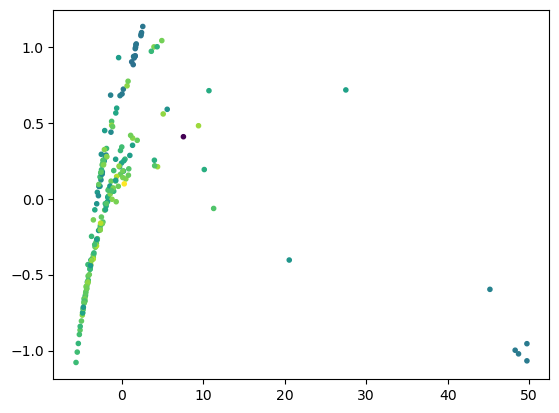

[0.9951677  0.00369294] 0.9988606


In [136]:
#@ CHEMICAL PROPERTIES:
logp = smiles_test.apply(Chem.MolFromSmiles).apply(Descriptors.MolLogP) 
pca = PCA(n_components=2)                                                   # Instantiating the PCA.
pca_r = pca.fit_transform(x_latent)
plt.figure()
plt.scatter(pca_r[:, 0], pca_r[:, 1], marker=".", c=logp)                   # Plotting the Scatter Plot. 
plt.show()                                                                  # Plotting the result. 
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_)) # Inspecting the result. 

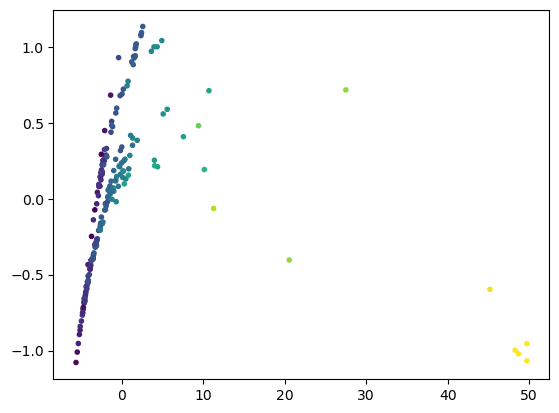

In [137]:
#@ CHEMICAL PROPERTIES:
mol_wt = smiles_test.apply(Chem.MolFromSmiles).apply(Descriptors.MolMR)
plt.figure()
plt.scatter(pca_r[:, 0], pca_r[:, 1], marker=".", c=mol_wt)                  # Plotting the Scatter Plot. 
plt.show()   

In [139]:
smiles_train = []
for individual_selfie in selfies_train:
        individual_smile = sf.decoder(individual_selfie)
        smiles_train.append(individual_smile)
smiles_train = pd.Series(smiles_train)

In [141]:
logp_train = smiles_train.apply(Chem.MolFromSmiles).apply(Descriptors.MolLogP)
logp_model = Sequential()                                                       # Initailizing the Sequential Model. 
logp_model.add(Dense(128, input_shape=(latent_dim, ), activation="relu"))       # Adding the first Dense Layer.
logp_model.add(Dense(128, activation="relu"))                                   # Adding the second Dense Layer. 
logp_model.add(Dense(1))                                                        # Output Dense Layer.
#@ COMPILING AND TRAINING THE MODEL:
logp_model.compile(optimizer="adam", loss="mse")                                # Compiling the Model. 
rlr = ReduceLROnPlateau(monitor="loss", factor=0.5, patience=10,
                        min_lr=0.000001, verbose=1, min_delta=1e-5)             # Initializing the Callbacks.
logp_model.fit(x_train_latent, logp_train, batch_size=128, epochs=40, 
               callbacks=[rlr])                                                 # Training the Model. 

NameError: name 'x_train_latent' is not defined